# Tutorial 07: Supervised learning with Python

---

## What we talked about last time
- Inferential statistics with scipy
- Linear regression with sklearn 

---

## Plan for today
- project announcement
- regression with sklearn
- optimization
- git and GitHub

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

---

## Linear regression

### Import data

In [2]:
inputs = np.load("inputs.npy")
targets = np.load("targets.npy")

Text(0, 0.5, 'y = f(x)')

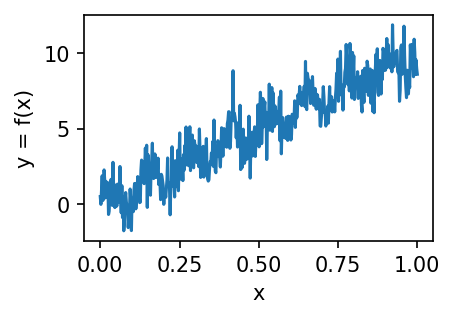

In [3]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(inputs, targets)
ax.set_xlabel("x")
ax.set_ylabel("y = f(x)")

### How well can we predict this data?

In [4]:
from sklearn.linear_model import LinearRegression

#### Is only using `x` enough on its own?

In [5]:
model = LinearRegression() # initialize the model
model.fit(inputs.reshape(-1, 1), targets) # fit the model

LinearRegression()

In [6]:
model.coef_

array([9.83679424])

In [7]:
model.intercept_

0.0884408769690408

In [8]:
predictions1 = model.coef_*inputs + model.intercept_

Text(0, 0.5, 'y = f(x)')

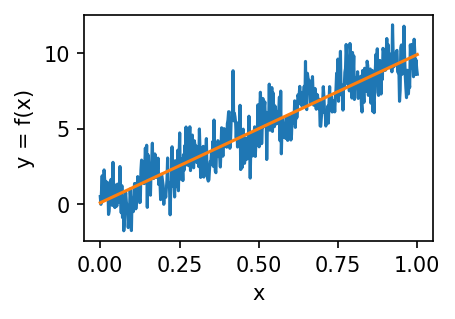

In [9]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(inputs, targets)
ax.plot(inputs, predictions1)
ax.set_xlabel("x")
ax.set_ylabel("y = f(x)")

Well, not so bad.. it does learn the general linear relationship, but no oscillations.

#### What about using some osciallating functions to compute additional "features"?

In [28]:
feat1 = inputs # feature 1

freq = 8
feat2 = np.sin(2*np.pi*freq*inputs) # feature 2

# combine the features into one single input array (samples as rows, features as columns)
X = np.hstack((feat1.reshape(-1, 1), feat2.reshape(-1, 1)))

In [29]:
X.shape

(500, 2)

In [30]:
model = LinearRegression()
model.fit(X, targets)

LinearRegression()

In [31]:
model.coef_ # w1 and w2

array([10.05045377,  0.90112487])

In [32]:
model.intercept_ # b

-0.018388889946931997

In [33]:
predictions2 = X @ model.coef_ + model.intercept_

Text(0, 0.5, 'y = f(x)')

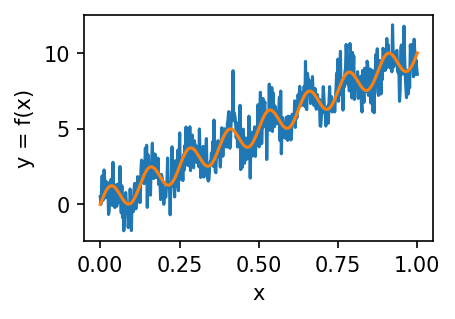

In [34]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(inputs, targets)
ax.plot(inputs, predictions2)
ax.set_xlabel("x")
ax.set_ylabel("y = f(x)")

### How can we quantify which fit/model is better?

To quantify the "goodness of fit" different measures can be used. One of the most commonly used ones is called Mean squared error (MSE), where we:
- compute the difference between the target and the prediction, for each sample
- square the difference
- average (or sum) across all samples

In [43]:
def loss_fn(targets, predictions):
    return np.sum((targets - predictions)**2)

In [44]:
loss_fn(targets, predictions1)

678.5122414915488

In [45]:
loss_fn(targets, predictions2)

477.82147073547253

---

## Finding the parameter of complex models: optimization

For simplicity, let's assume we know the `freq=8`, second weight `w2=0.5`, and the intercept `c=0.0`. Our goal then is to find `w1=?`

Often, complex models, do not have a solution. In other words, it is not easy to come up with a mathemtical equation that directly gives us `w1` as a function of inputs and targets.

Let's clean up our prediction and loss function first

In [47]:
def predict(inputs, freq, w1, w2, b):
    feat1 = inputs
    feat2 = np.sin(2 * np.pi * freq * inputs)
    return w1 * feat1 + w2 * feat2 + b
    
def loss_fn(inputs, targets, freq, w1, w2, b):
    predictions = predict(inputs, freq, w1, w2, b)
    return np.sum((targets - predictions)**2)

### Aproach 1: try many values of `w1`, pick the best

In [48]:
w1_range = np.linspace(0, 20, 100)

In [50]:
losses = []
for w1 in w1_range:
    loss = loss_fn(inputs, targets, 8., w1, 0.5, 0.)
    losses.append(loss)

Text(0, 0.5, 'Loss')

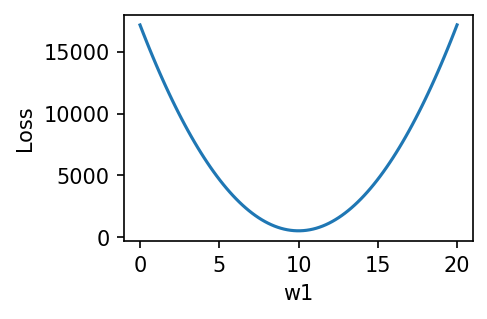

In [51]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(w1_range, losses)
ax.set_xlabel("w1")
ax.set_ylabel("Loss")

We can then find the `w1` value that corresponds to the minimum loss value:

In [58]:
w1_range[np.argmin(losses)]

9.8989898989899

Not bad. But... <br>
this approach becomes very expensive, computationally, as soon as we have higher number of parameters. Many of the state of the art parameters have $>100k$ unknown parameter. even if you try 5 values per parameters, you will have to go through $5 ^ {>100k}$ configurations.

In these cases, we resort to an itertative approach, also referred to as **optimization**. 

#### The general setup for optimization is as follows:
- we define our goal/objective (commonly referred to as **objective function** or **loss function**): our goal is minimize the difference between our prediction and the actual outputs.
- how can we achieve our goal? -> by changing the parameters of our model. In this example, our only unknown parameter is `w1`.
- we then systematically try different values of `w1` and choose the one that helps us achieve our goal best (i.e. minimize the loss function)

### Aproach 2: try values of `w1` that take you a step closer to your objective (i.e. minimizing loss)

Text(0, 0.5, 'Loss')

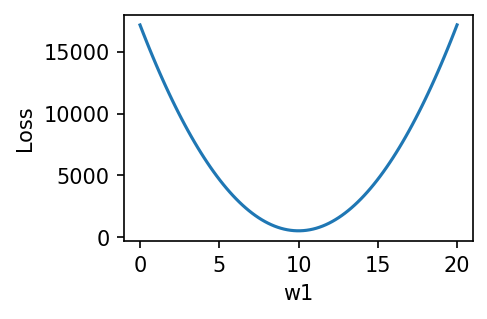

In [59]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(w1_range, losses)
ax.set_xlabel("w1")
ax.set_ylabel("Loss")

### The specific steps of the optimization:
1. pick an initial value for the unknown parameter
2. evaluate the gradient at the value
3. update the parameter using the gradient and a stepsize (aka learning rate)
4. repeat steps 2-3 until your loss does not decrease anymore

In [60]:
w1 = 2.5
learning_rate = .001 # step size

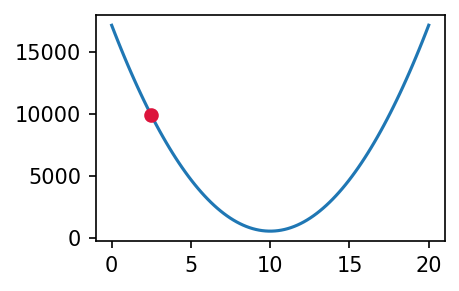

In [61]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)

# loss landscape for reference
ax.plot(w1_range, losses, zorder=0)

# what is the loss at this specific w1 value?
ax.scatter(w1, loss_fn(inputs, targets, 8., w1, 0.5, 0.0), c='crimson', zorder=1)

# what is the gradient at this specific w1 value?
# ...

### Automatic differentiation with [JAX](https://github.com/google/jax)
![](https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png)

In [62]:
from jax import grad

In [71]:
loss_grad_fn = grad(loss_fn, argnums=3)

In [72]:
loss_grad_fn(inputs, targets, 8., w1, 0.5, 0.0).item()

-2502.18798828125

Now with this function that computes the gradient for us we can complete our optimization steps:

In [84]:
w1 = 5.
learning_rate = .001

Text(0, 0.5, 'Loss')

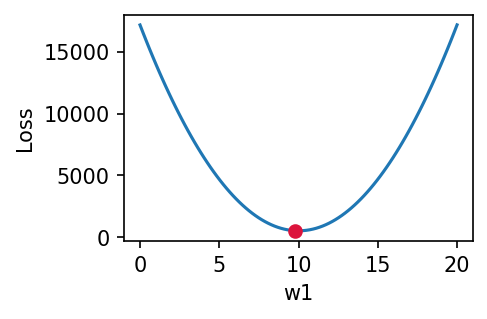

In [93]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)

# plot the loss "landscape" for reference
ax.plot(w1_range, losses, zorder=0)

# what is the loss at this specific w1 value?
loss = loss_fn(inputs, targets, 8., w1, 0.5, 0.0)
ax.scatter(w1, loss, c='crimson', zorder=1)

# what is the gradient at this specific w1 value?
grad_val = loss_grad_fn(inputs, targets, 8., w1, 0.5, 0.0).item()

# update w1 value
w1 = w1 - learning_rate * grad_val

ax.set_xlabel("w1")
ax.set_ylabel("Loss")

In [129]:
w1s, w1_losses = [], []

w1 = 5. # initial value
learning_rate = 0.0062 # .006 is the sweet spot. >0.006: unstable, <0.006: converges

Text(0, 0.5, 'Loss')

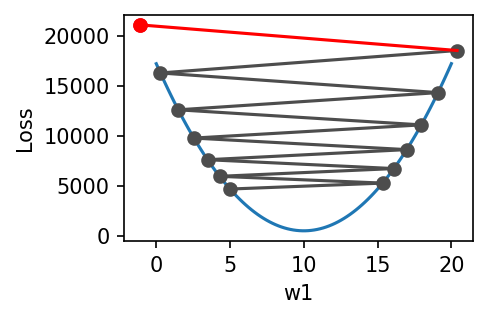

In [142]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)

# plot the loss "landscape" for reference
ax.plot(w1_range, losses, zorder=0)

# what is the loss at this specific w1 value?
loss = loss_fn(inputs, targets, 8., w1, 0.5, 0.0)
ax.scatter(w1, loss, c='crimson', zorder=1)

# Keep track of the points
w1s.append(w1)
w1_losses.append(loss)

# what is the gradient at this specific w1 value?
grad_val = loss_grad_fn(inputs, targets, 8., w1, 0.5, 0.0).item()

# update w1 value
w1 = w1 - learning_rate * grad_val

# plot the trajectory
if len(w1s)>1:
    for i in range(len(w1s)-1):
        ax.scatter(w1s[i], w1_losses[i], c='.3')
        ax.plot([w1s[i], w1s[i+1]], [w1_losses[i], w1_losses[i+1]], c='red' if i+1 == len(w1s)-1 else ".3")
    
    ax.scatter(w1s[-1], w1_losses[-1], c='red')
    
ax.set_xlabel("w1")
ax.set_ylabel("Loss")

---

### [Bonus] What if we did not know the `freq` parameter?

When using JAX, It is recommended to use the `numpy` module of JAX instead of the numpy package directly

In [65]:
import jax.numpy as jnp

We can now simply repalce `np` by `jnp` in our prediction and loss function.

In [66]:
def predict(inputs, freq, w1, w2, b):
    feat1 = inputs
    feat2 = jnp.sin(2 * np.pi * freq * inputs)
    return w1 * feat1 + w2 * feat2 + b
    
def loss_fn(inputs, targets, freq, w1, w2, b):
    predictions = predict(inputs, freq, w1, w2, b)
    return jnp.sum((targets - predictions)**2)

Let's check the loss "landscape" as a function of the `freq` parameter

In [67]:
freq_range = np.linspace(5, 15, 1000)

In [68]:
losses = []
for freq in freq_range:
    loss = loss_fn(inputs, targets, freq, 1., 0.5, 0.)
    losses.append(loss)

Text(0, 0.5, 'Loss')

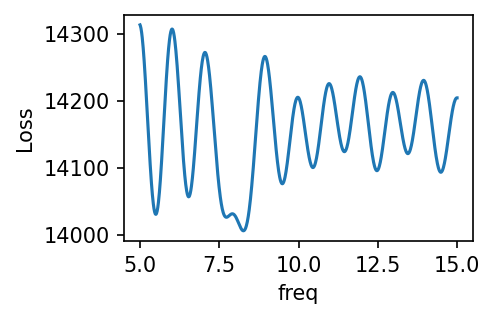

In [69]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(freq_range, losses)

ax.set_xlabel("freq")
ax.set_ylabel("Loss")

Let's define the function that gives us the gradient wrt to `freq`, at a specific parameter values.

In [70]:
loss_grad_fn = grad(loss_fn, argnums=2)

And repeat the same procedure as we did with `w1`, but this time with `freq` parameter of our model.

In [71]:
freqs, freq_losses = [], []

freq = 7. # initial value
learning_rate = 0.001 # .006 is the sweet spot. >0.006: unstable, <0.006: converges

-746.1994018554688


Text(0, 0.5, 'Loss')

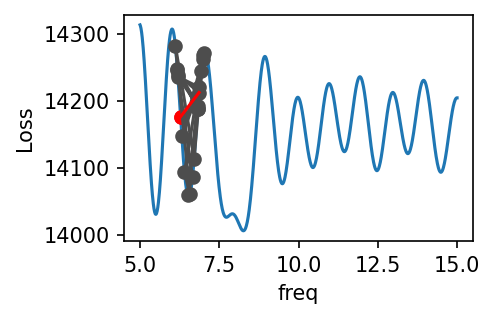

In [92]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)

# plot the loss "landscape" for reference
ax.plot(freq_range, losses, zorder=0)

# what is the loss at this specific w1 value?
loss = loss_fn(inputs, targets, freq, 1., 0.5, 0.0)
ax.scatter(freq, loss, c='crimson', zorder=1)

# Keep track of the points
freqs.append(freq)
freq_losses.append(loss)

# what is the gradient at this specific w1 value?
grad_val = loss_grad_fn(inputs, targets, freq, 1., 0.5, 0.0).item()

print(grad_val)

# update w1 value
freq = freq - learning_rate * grad_val

# plot the trajectory
if len(freqs)>1:
    for i in range(len(freqs)-1):
        ax.scatter(freqs[i], freq_losses[i], c='.3')
        ax.plot([freqs[i], freqs[i+1]], [freq_losses[i], freq_losses[i+1]], c='red' if i+1 == len(freqs)-1 else ".3")
    
    ax.scatter(freqs[-1], freq_losses[-1], c='red')
    
ax.set_xlabel("freq")
ax.set_ylabel("Loss")

### What is the problem here?